# Proyek Klasifikasi Gambar: Klasifikasi Sampah
- **Nama:** Fitria Anggraini
- **Email:** ftranggra23@gmail.com
- **ID Dicoding:** ftriaanggra23

## Import Semua Packages/Library yang Digunakan

In [ ]:
#Memeriksa GPU NVIDIA yang tersedia dan statusnya
!nvidia-smi

Sat Apr 19 09:14:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q tensorflow tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import zipfile
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from google.colab import drive
from PIL import Image, ImageOps
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs
import tensorflow.lite as tflite

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Konfirmasi versi TensorFlow
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


## Data Preparation

### Data Loading

In [ ]:
drive.mount('/content/drive')

# Path file zip di gdrive
zip_path = "/content/drive/MyDrive/Colab Notebooks/laskar ai/submission2_klasifikasi_sampah/garbage_dataset.zip"

# Ekstrak isi zip
!unzip -q "{zip_path}" -d /content/

dataset_path = "/content/garbage_dataset"
os.listdir(dataset_path)

Mounted at /content/drive


['plastic',
 'battery',
 'metal',
 'biological',
 'cardboard',
 'clothes',
 'paper',
 'glass',
 'shoes']

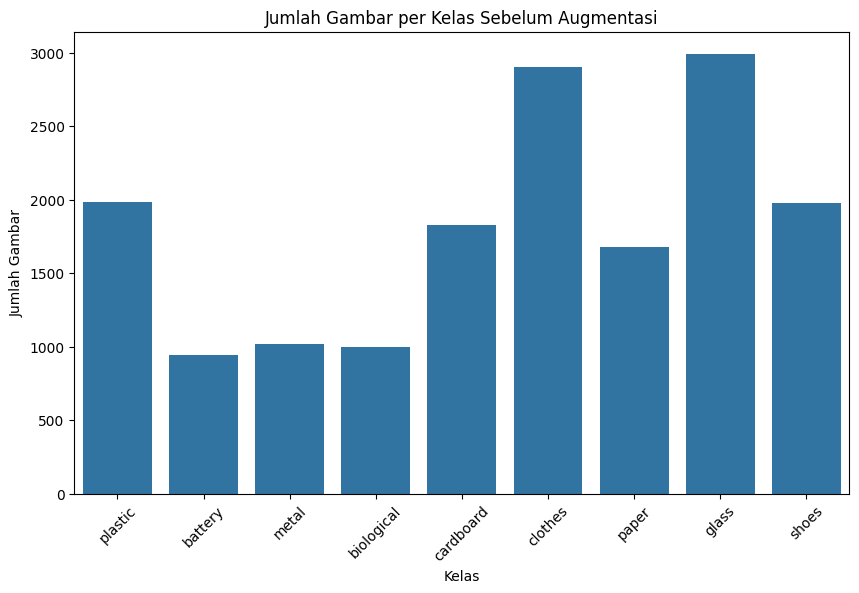

In [ ]:
class_names = os.listdir(dataset_path)
data_counter = {}
for class_name in class_names:
    folder_path = os.path.join(dataset_path, class_name)
    data_counter[class_name] = len(os.listdir(folder_path))

plt.figure(figsize=(10,6))
sns.barplot(x=list(data_counter.keys()), y=list(data_counter.values()))
plt.title("Jumlah Gambar per Kelas Sebelum Augmentasi")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

In [ ]:
def show_sample_images(folder_path, title):
    fig, axes = plt.subplots(1, 5, figsize=(15,3))
    fig.suptitle(title)
    for i, img_name in enumerate(os.listdir(folder_path)[:5]):
        img = Image.open(os.path.join(folder_path, img_name))
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

for class_name in class_names:
    show_sample_images(os.path.join(dataset_path, class_name), f"Contoh Gambar Kelas: {class_name}")

Output hidden; open in https://colab.research.google.com to view.

### Data Preprocessing

#### Resize dan Augmentasi

In [ ]:
resize_dim = (224, 224)
aug_classes = ['metal', 'biological', 'battery']

def resize_with_padding(img, size, padding_color=(0, 0, 0)):
    old_size = img.size
    ratio = min(size[0]/old_size[0], size[1]/old_size[1])
    new_size = tuple([int(x * ratio) for x in old_size])
    img = img.resize(new_size, Image.Resampling.LANCZOS)

    new_img = Image.new("RGB", size, padding_color)
    new_img.paste(img, ((size[0]-new_size[0])//2, (size[1]-new_size[1])//2))
    return new_img

for class_name in class_names:
    folder_path = os.path.join(dataset_path, class_name)

    # Resize semua gambar dengan padding
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path).convert('RGB')
        img = resize_with_padding(img, resize_dim)
        img.save(img_path)

    # Augmentasi khusus kelas minoritas
    if class_name in aug_classes:
        img_list = os.listdir(folder_path)[:int(len(os.listdir(folder_path)) * 0.5)]
        for img_name in img_list:
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path).convert('RGB')

            # Rotasi searah jarum jam
            rotated_cw = img.transpose(Image.Transpose.ROTATE_90)
            rotated_cw = resize_with_padding(rotated_cw, resize_dim)
            rotated_cw.save(os.path.join(folder_path, f"aug_cw_{img_name}"))

            # Rotasi berlawanan arah jarum jam
            rotated_ccw = img.transpose(Image.Transpose.ROTATE_270)
            rotated_ccw = resize_with_padding(rotated_ccw, resize_dim)
            rotated_ccw.save(os.path.join(folder_path, f"aug_ccw_{img_name}"))

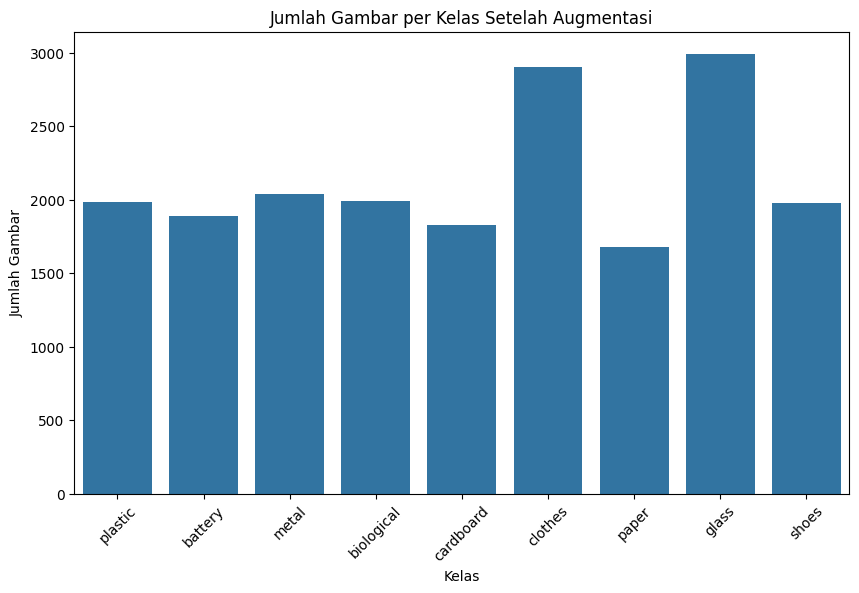

In [ ]:
data_counter_aug = {}
for class_name in class_names:
    folder_path = os.path.join(dataset_path, class_name)
    data_counter_aug[class_name] = len(os.listdir(folder_path))

plt.figure(figsize=(10,6))
sns.barplot(x=list(data_counter_aug.keys()), y=list(data_counter_aug.values()))
plt.title("Jumlah Gambar per Kelas Setelah Augmentasi")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

#### Split Dataset

In [ ]:
# Split 70/15/15
base_dir = "/content/garbage_split"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    for split in ['train', 'val', 'test']:
        for class_name in class_names:
            os.makedirs(os.path.join(base_dir, split, class_name))

    for class_name in class_names:
        src = os.path.join(dataset_path, class_name)
        imgs = os.listdir(src)
        np.random.shuffle(imgs)
        total = len(imgs)
        train_end = int(0.7 * total)
        val_end = int(0.9 * total)

        for i, img_name in enumerate(imgs):
            dst_folder = 'train' if i < train_end else 'val' if i < val_end else 'test'
            shutil.copy(os.path.join(src, img_name), os.path.join(base_dir, dst_folder, class_name, img_name))

## Modelling

In [ ]:
# Data generator
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=resize_dim,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=resize_dim,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=resize_dim,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 13495 images belonging to 9 classes.
Found 3856 images belonging to 9 classes.
Found 1932 images belonging to 9 classes.


In [ ]:
num_classes = train_generator.num_classes  # otomatis sesuai folder train

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # otomatis sesuai jumlah kelas
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,185 (1.87 MB)

 Trainable params: 489,225 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callback
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

In [ ]:
# Training
history = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=callbacks)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2749 - loss: 2.0165

422/422 ━━━━━━━━━━━━━━━━━━━━ 52s 92ms/step - accuracy: 0.2751 - loss: 2.0161 - val_accuracy: 0.2363 - val_loss: 2.0628 - learning_rate: 1.0000e-04
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4415 - loss: 1.5974

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.4415 - loss: 1.5973 - val_accuracy: 0.5140 - val_loss: 1.3847 - learning_rate: 1.0000e-04
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4902 - loss: 1.4564

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.4902 - loss: 1.4564 - val_accuracy: 0.5397 - val_loss: 1.3036 - learning_rate: 1.0000e-04
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5341 - loss: 1.3573

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - accuracy: 0.5341 - loss: 1.3573 - val_accuracy: 0.5747 - val_loss: 1.2368 - learning_rate: 1.0000e-04
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5528 - loss: 1.2836

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.5528 - loss: 1.2835 - val_accuracy: 0.6206 - val_loss: 1.1189 - learning_rate: 1.0000e-04
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5857 - loss: 1.2090

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.5857 - loss: 1.2090 - val_accuracy: 0.6263 - val_loss: 1.0875 - learning_rate: 1.0000e-04
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6016 - loss: 1.1550

422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 87ms/step - accuracy: 0.6016 - loss: 1.1550 - val_accuracy: 0.6387 - val_loss: 1.0634 - learning_rate: 1.0000e-04
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6229 - loss: 1.0908

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.6229 - loss: 1.0908 - val_accuracy: 0.6725 - val_loss: 0.9480 - learning_rate: 1.0000e-04
Epoch 9/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.6412 - loss: 1.0433 - val_accuracy: 0.6600 - val_loss: 0.9784 - learning_rate: 1.0000e-04
Epoch 10/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6489 - loss: 1.0063

422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.6489 - loss: 1.0063 - val_accuracy: 0.6859 - val_loss: 0.9336 - learning_rate: 1.0000e-04
Epoch 11/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6764 - loss: 0.9549

422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.6764 - loss: 0.9549 - val_accuracy: 0.7020 - val_loss: 0.8794 - learning_rate: 1.0000e-04
Epoch 12/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.6873 - loss: 0.9258 - val_accuracy: 0.6769 - val_loss: 0.9540 - learning_rate: 1.0000e-04
Epoch 13/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.7086 - loss: 0.8809 - val_accuracy: 0.7015 - val_loss: 0.8913 - learning_rate: 1.0000e-04
Epoch 14/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7175 - loss: 0.8329

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.7175 - loss: 0.8329 - val_accuracy: 0.7383 - val_loss: 0.7786 - learning_rate: 1.0000e-04
Epoch 15/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.7327 - loss: 0.7938 - val_accuracy: 0.7326 - val_loss: 0.7791 - learning_rate: 1.0000e-04
Epoch 16/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.7495 - loss: 0.7450 - val_accuracy: 0.7181 - val_loss: 0.8564 - learning_rate: 1.0000e-04
Epoch 17/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7578 - loss: 0.7394

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.7578 - loss: 0.7394 - val_accuracy: 0.7503 - val_loss: 0.7452 - learning_rate: 1.0000e-04
Epoch 18/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7723 - loss: 0.6934

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.7723 - loss: 0.6934 - val_accuracy: 0.7842 - val_loss: 0.6667 - learning_rate: 1.0000e-04
Epoch 19/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 32s 76ms/step - accuracy: 0.7846 - loss: 0.6544 - val_accuracy: 0.7396 - val_loss: 0.7968 - learning_rate: 1.0000e-04
Epoch 20/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.7884 - loss: 0.6290 - val_accuracy: 0.7627 - val_loss: 0.7209 - learning_rate: 1.0000e-04
Epoch 21/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8039 - loss: 0.5890

422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.8039 - loss: 0.5890 - val_accuracy: 0.7837 - val_loss: 0.6557 - learning_rate: 1.0000e-04
Epoch 22/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.8120 - loss: 0.5705 - val_accuracy: 0.7759 - val_loss: 0.6798 - learning_rate: 1.0000e-04
Epoch 23/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.8140 - loss: 0.5475 - val_accuracy: 0.7461 - val_loss: 0.8202 - learning_rate: 1.0000e-04
Epoch 24/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.8289 - loss: 0.5212 - val_accuracy: 0.7121 - val_loss: 0.9224 - learning_rate: 1.0000e-04
Epoch 25/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8614 - loss: 0.4377

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8614 - loss: 0.4376 - val_accuracy: 0.8195 - val_loss: 0.5695 - learning_rate: 3.0000e-05
Epoch 26/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8680 - loss: 0.3993

422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8680 - loss: 0.3993 - val_accuracy: 0.8288 - val_loss: 0.5419 - learning_rate: 3.0000e-05
Epoch 27/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.8782 - loss: 0.3716 - val_accuracy: 0.8244 - val_loss: 0.5573 - learning_rate: 3.0000e-05
Epoch 28/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.8867 - loss: 0.3549 - val_accuracy: 0.8255 - val_loss: 0.5658 - learning_rate: 3.0000e-05
Epoch 29/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.8838 - loss: 0.3536 - val_accuracy: 0.8294 - val_loss: 0.5466 - learning_rate: 3.0000e-05
Epoch 30/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8915 - loss: 0.3373

422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.8915 - loss: 0.3373 - val_accuracy: 0.8348 - val_loss: 0.5163 - learning_rate: 9.0000e-06
Epoch 31/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8979 - loss: 0.3219

422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.8979 - loss: 0.3219 - val_accuracy: 0.8431 - val_loss: 0.5033 - learning_rate: 9.0000e-06
Epoch 32/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.8961 - loss: 0.3121 - val_accuracy: 0.8361 - val_loss: 0.5177 - learning_rate: 9.0000e-06
Epoch 33/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.8996 - loss: 0.3162 - val_accuracy: 0.8410 - val_loss: 0.5124 - learning_rate: 9.0000e-06
Epoch 34/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9020 - loss: 0.2967 - val_accuracy: 0.8405 - val_loss: 0.5067 - learning_rate: 9.0000e-06
Epoch 35/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9077 - loss: 0.2941

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9077 - loss: 0.2941 - val_accuracy: 0.8441 - val_loss: 0.5009 - learning_rate: 2.7000e-06
Epoch 36/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9034 - loss: 0.3038 - val_accuracy: 0.8413 - val_loss: 0.5036 - learning_rate: 2.7000e-06
Epoch 37/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9039 - loss: 0.2928

422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.9039 - loss: 0.2928 - val_accuracy: 0.8413 - val_loss: 0.5008 - learning_rate: 2.7000e-06
Epoch 38/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9020 - loss: 0.2973 - val_accuracy: 0.8413 - val_loss: 0.5025 - learning_rate: 2.7000e-06
Epoch 39/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.9098 - loss: 0.2947 - val_accuracy: 0.8431 - val_loss: 0.5023 - learning_rate: 2.7000e-06
Epoch 40/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9045 - loss: 0.3013 - val_accuracy: 0.8405 - val_loss: 0.5021 - learning_rate: 2.7000e-06
Epoch 41/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - accuracy: 0.9072 - loss: 0.2891 - val_accuracy: 0.8428 - val_loss: 0.5010 - learning_rate: 8.1000e-07
Epoch 42/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/step - accuracy: 0.9082 - loss: 0.2870 - val_accuracy: 0.8434 - val_loss: 0.5009 - learning_rate: 8.1000e-07
Epoch 43/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 72ms/st

## Evaluasi dan Visualisasi

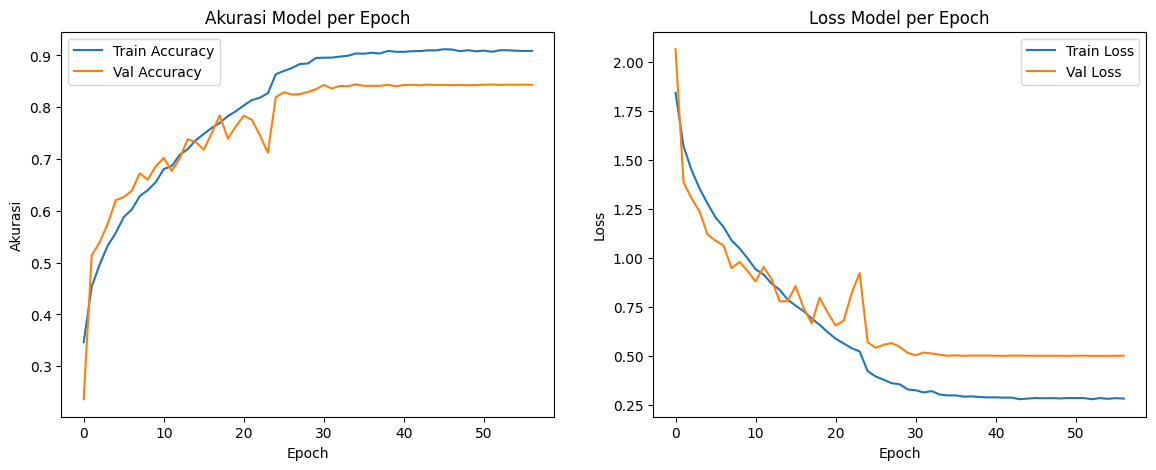

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.88      0.87      0.88       189
  biological       0.88      0.94      0.91       200
   cardboard       0.88      0.86      0.87       183
     clothes       0.92      0.93      0.93       291
       glass       0.84      0.84      0.84       300
       metal       0.84      0.84      0.84       204
       paper       0.84      0.88      0.86       168
     plastic       0.77      0.74      0.76       199
       shoes       0.85      0.79      0.82       198

    accuracy                           0.86      1932
   macro avg       0.86      0.86      0.85      1932
weighted avg       0.86      0.86      0.86      1932



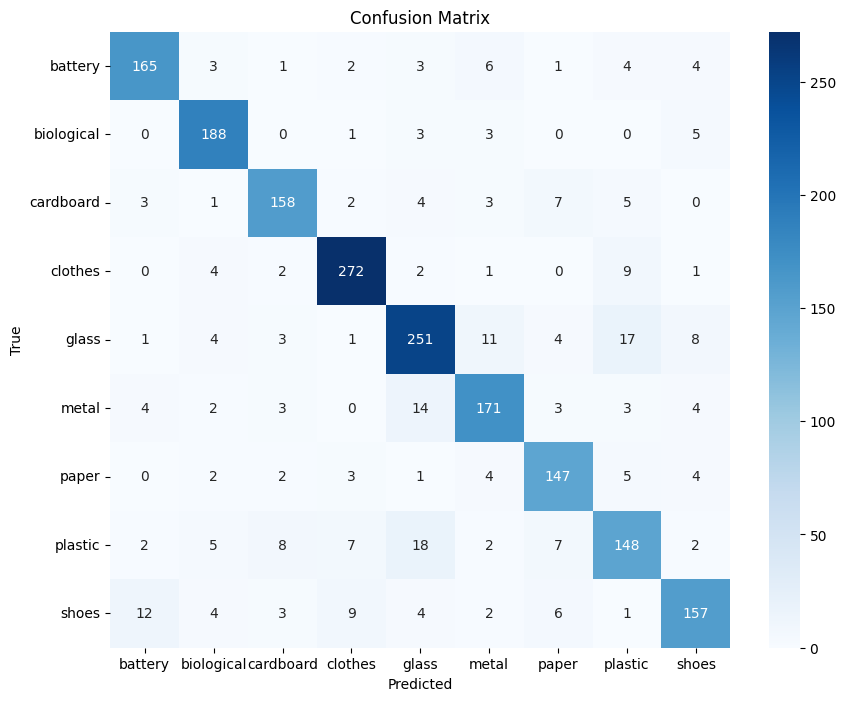

In [ ]:
# Evaluasi model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Konversi Model

In [ ]:
saved_model_path = "/content/submission/saved_model"
os.makedirs(saved_model_path, exist_ok=True)
model.export(saved_model_path)

Saved artifact at '/content/submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  132502654581648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502654582416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658812432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658812816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658811472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658811664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502654581840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658813392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658813776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132502658810512: TensorSpec(shape=(), dtype=tf.resource, name=None)
 

In [ ]:
tfjs_path = "/content/submission/tfjs_model"
os.makedirs(tfjs_path, exist_ok=True)
tfjs.converters.save_keras_model(model, tfjs_path)

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
tflite_path = "/content/submission/tflite/model.tflite"
os.makedirs(os.path.dirname(tflite_path), exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']
label_path = "/content/submission/tflite/label.txt"
with open(label_path, "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

## Inference (Optional)


Kelas Asli: battery
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
Hasil Prediksi: battery (89.61%) dari gambar: aug_cw_battery_379.jpg


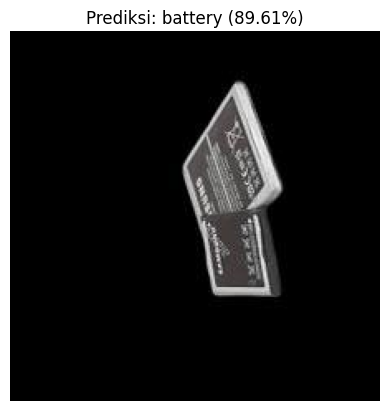


Kelas Asli: biological
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Hasil Prediksi: biological (99.93%) dari gambar: biological_472.jpg


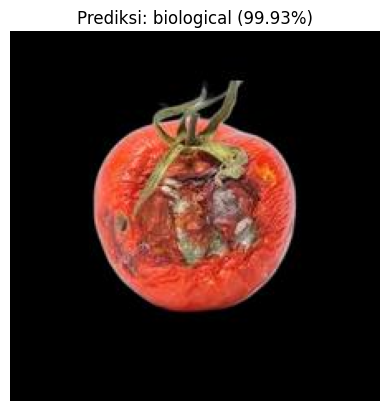


Kelas Asli: cardboard
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Hasil Prediksi: paper (58.17%) dari gambar: cardboard_2000.jpg


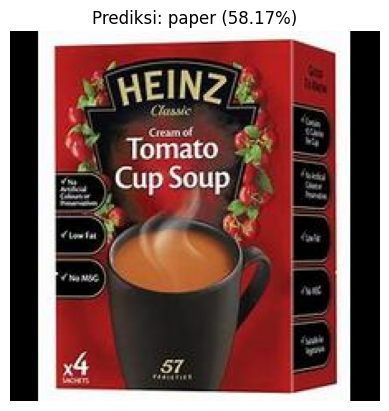


Kelas Asli: clothes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hasil Prediksi: clothes (98.14%) dari gambar: clothes_4179.jpg


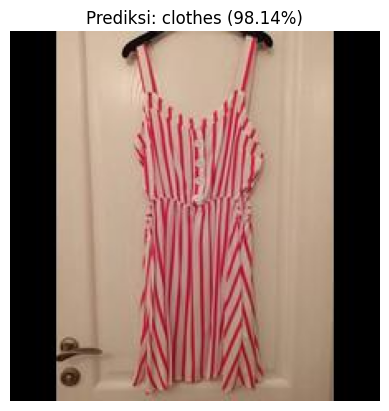


Kelas Asli: glass
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Hasil Prediksi: glass (99.81%) dari gambar: glass_623.jpg


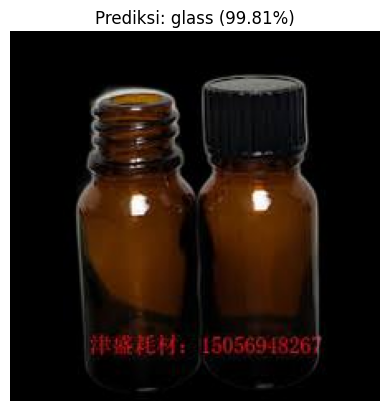


Kelas Asli: metal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Hasil Prediksi: metal (99.95%) dari gambar: aug_ccw_metal_2274.jpg


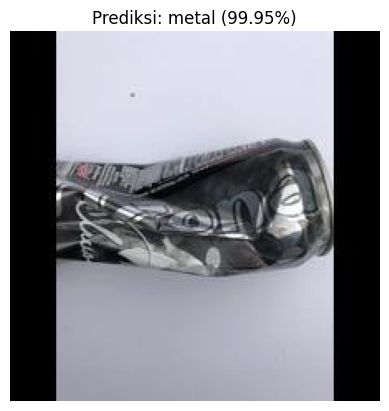


Kelas Asli: paper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Hasil Prediksi: paper (90.05%) dari gambar: paper_3044.jpg


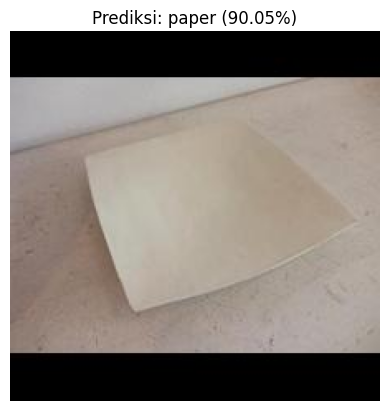


Kelas Asli: plastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Hasil Prediksi: plastic (73.15%) dari gambar: plastic_305.jpg


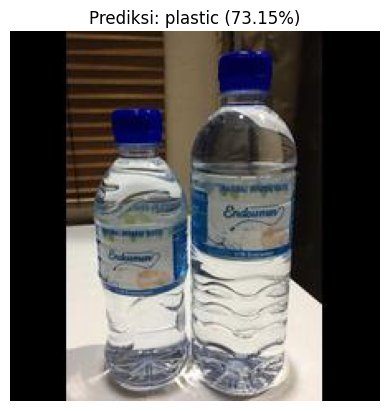


Kelas Asli: shoes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Hasil Prediksi: shoes (99.91%) dari gambar: shoes_1091.jpg


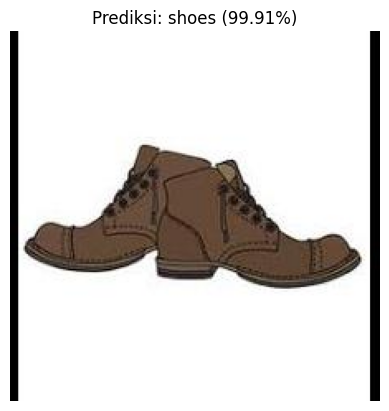

In [ ]:
from tensorflow.keras.preprocessing import image

class_labels = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes']
test_base_path = "/content/garbage_split/test"

def predict_image(img_path, model, class_labels):
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Show result
    print(f"Hasil Prediksi: {predicted_class} ({confidence*100:.2f}%) dari gambar: {os.path.basename(img_path)}")
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()

# Loop semua kelas dan ambil 1 gambar random tiap kelas
for label in class_labels:
    class_dir = os.path.join(test_base_path, label)
    if not os.path.exists(class_dir) or len(os.listdir(class_dir)) == 0:
        print(f"Folder kosong atau tidak ditemukan: {class_dir}")
        continue

    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    print(f"\nKelas Asli: {label}")
    predict_image(img_path, model, class_labels)